Καμάρης Άγγελος
sdi1900070

**Τεχνητή Νοημοσύνη ΙΙ**

(ακαδ. έτος 2022-23)

In [101]:
#headers used throughout the programm
from google.colab import drive
drive.mount('/content/drive')
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from gensim.scripts.glove2word2vec import glove2word2vec


from gensim.models import KeyedVectors
import warnings

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


--2022-12-23 15:24:52--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-12-23 15:24:52--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-23 15:24:52--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

In [102]:
file=open('/content/drive/MyDrive/imdb-reviews.csv','r', encoding="utf-8")

df= pd.read_csv(file, sep='\t' , on_bad_lines='skip')       #open the file stored in the drive and seperate it by tabs
test_df = None

#test_df=pd.read_csv("file name", sep='\t' , on_bad_lines='skip')   #you can use this to create a test dataframe, but you must enter the filename of the variable that holds the file.

print(df)

df.describe()

                                                    url  rating  \
0      http://www.imdb.com/title/tt0120623/usercomments    10.0   
1      http://www.imdb.com/title/tt0043117/usercomments     9.0   
2      http://www.imdb.com/title/tt0043117/usercomments    10.0   
3      http://www.imdb.com/title/tt0835204/usercomments     4.0   
4      http://www.imdb.com/title/tt0499603/usercomments    10.0   
...                                                 ...     ...   
45003  http://www.imdb.com/title/tt0449000/usercomments     1.0   
45004  http://www.imdb.com/title/tt0109382/usercomments     1.0   
45005  http://www.imdb.com/title/tt0375560/usercomments     1.0   
45006  http://www.imdb.com/title/tt0165107/usercomments     1.0   
45007  http://www.imdb.com/title/tt0041513/usercomments    10.0   

                                                  review  
0      I thought this was a quiet good movie. It was ...  
1      Wagon Master is a very unique film amongst Joh...  
2      This film h

,rating
count,45008.000000
mean,5.481914
std,3.494293
min,1.000000
25%,2.000000
50%,7.000000
75%,9.000000
max,10.000000


In [103]:
def preprocess(df):       #This function 

  stopwords = nltk.corpus.stopwords.words("english")      #make a list of stopwords, from the english language

  df['review'] = df['review'].astype(str).str.lower()     #make everything lowercase
  regexp = RegexpTokenizer('\w+')
  df['review']=df['review'].apply(regexp.tokenize)        #tokenize the reviews from strings to lists of words


  bigwords = df['review'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))      #keep only words that contain more that 2 letters

  all_words = ' '.join([word for word in bigwords])      #merge them and tokenize them again to create a frequency dictionary
  tw = nltk.tokenize.word_tokenize(all_words)

  fdist = FreqDist(tw)


  df['review'] = df['review'].apply(lambda x: ' '.join([item for item in x if fdist[item] >= 1 ]))  #remove not frequent words


  lem = WordNetLemmatizer()

  df['review'] = df['review'].apply(lem.lemmatize)                  #lematize



  
preprocess(df)

if test_df != None:                     #if a testset is given, preprocess it
  preprocess(test_df)

In [104]:
X=df.drop('rating', axis=1)
X=df.drop('url', axis=1)
Y = df[['rating']] # [[ ]] used to keep the label
Y.loc[Y['rating'] <= 4, 'rating'] = 0                 #keep only valuable data, for X and Y
Y.loc[Y['rating'] >= 7, 'rating'] = 1


if test_df == None:
  X_train_unvect, X_test_unvect, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)              #if we are not given a test set, we will split our current data.
else:
  X_train_unvect = X
  Y_train = Y
  X_test_unvect = test_df.drop('rating', axis=1)
  X_test_unvect = test_df.drop('url', axis=1)
  Y_test = test_df[['rating']] # [[ ]] used to keep the label

  Y_test.loc[Y_test['rating'] <= 4, 'rating'] = 0
  Y_test.loc[Y_test['rating'] >= 7, 'rating'] = 1


glove_input_file = 'glove.6B.300d.txt'
w2v_output_file = 'glv_with_w2v_format.txt'


glove2word2vec(glove_input_file, w2v_output_file)


data=X_train_unvect['review']
data2=X_test_unvect['review']



model = KeyedVectors.load_word2vec_format(w2v_output_file, binary=False)

warnings.simplefilter(action='ignore', category=FutureWarning)

X_train=[]
X_test=[]

temp=0
for row in data.str.split():
  sum=0;
  c=0;
  for w in row:
    if w in model.vocab:
      sum+=model[w]
      temp=model[w]
      c+=1
  X_train.append(sum/c)

temp=0
for row in data2.str.split():
  sum=0;
  c=0;
  for w in row:
    if w in model.vocab:
      sum+=model[w]
      temp=model[w]
      c+=1
  X_test.append(sum/c)




/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


[array([-5.68554439e-02,  1.11776009e-01, -1.03159053e-02, -1.18885741e-01,
       -1.97530426e-02,  5.06167002e-02, -6.21122271e-02,  3.16484384e-02,
        3.16984802e-02, -1.40906787e+00,  9.45312157e-02, -2.95234323e-02,
       -6.28512949e-02,  1.40236646e-01,  3.14150080e-02, -3.43812294e-02,
       -9.08978134e-02, -3.85370404e-02,  2.28393134e-02,  2.23532319e-02,
        3.21877077e-02,  2.34390885e-01,  1.77310109e-01,  1.31547585e-01,
       -1.37273133e-01,  1.57656725e-02,  4.17093746e-02, -1.14100508e-01,
       -8.00742507e-02,  1.15603969e-01, -8.22080672e-03,  1.92564979e-01,
       -1.96747720e-01,  7.02115521e-02, -6.99058771e-01,  4.04390097e-02,
       -3.03137880e-02,  9.85788181e-02,  2.55894382e-02,  2.00050808e-02,
        8.28739163e-03, -1.14080198e-01, -4.04885337e-02,  5.22624329e-02,
        6.61622435e-02,  1.02745548e-01,  6.75420314e-02,  4.24571373e-02,
       -4.86006625e-02,  6.64330721e-02,  1.01541385e-01, -1.37324005e-01,
        8.84248391e-02, 

In [105]:
X_train_tor=torch.tensor(np.array(X_train), dtype=torch.float)
X_test_tor=torch.tensor(np.array(X_test), dtype=torch.float)
Y_train_tor=torch.tensor(np.array(Y_train), dtype=torch.float)
Y_test_tor=torch.tensor(np.array(Y_test), dtype=torch.float)


print(f"x train shape: {X_train_tor.shape}")
print(f"x test shape: {X_test_tor.shape}")
print(f"y train shape: {Y_train_tor.shape}")
print(f"y test shape: {Y_test_tor.shape}")

x train shape: torch.Size([31505, 300])
x test shape: torch.Size([13503, 300])
y train shape: torch.Size([31505, 1])
y test shape: torch.Size([13503, 1])


In [106]:
class Net(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out):
        super(Net, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H3, D_out)
        
    def forward(self, x):
        h1 = self.linear1(x)
        h2 = self.linear2(h1)
        h3 = self.linear3(h2)
        out= self.linear4(h3)
        return out

In [107]:
#Define layer sizes
D_in = X_train_tor.shape[1]
H1 = 300
H2 = 150
H3 = 75
D_out = 1

#Define Hyperparameters
learning_rate = 1e-3

#Initialise model, loss, optimizer
model = Net(D_in, H1, H2, H3, D_out)
loss_func = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate)

#Initialise dataloader
dataset = torch.utils.data.TensorDataset(X_train_tor, Y_train_tor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=20, shuffle=False)

In [108]:
model

Net(
  (linear1): Linear(in_features=300, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=150, bias=True)
  (linear3): Linear(in_features=150, out_features=75, bias=True)
  (linear4): Linear(in_features=75, out_features=1, bias=True)
)

Epoch   0: Loss = 5.55164
Epoch   1: Loss = 4.74059
Epoch   2: Loss = 4.42716
Epoch   3: Loss = 4.04225
Epoch   4: Loss = 3.68138
Epoch   5: Loss = 3.43459
Epoch   6: Loss = 3.27688
Epoch   7: Loss = 3.16424
Epoch   8: Loss = 3.07899
Epoch   9: Loss = 3.01334
Epoch  10: Loss = 2.96190
Epoch  11: Loss = 2.92069
Epoch  12: Loss = 2.88696
Epoch  13: Loss = 2.85885
Epoch  14: Loss = 2.83511
Epoch  15: Loss = 2.81487
Epoch  16: Loss = 2.79747
Epoch  17: Loss = 2.78241
Epoch  18: Loss = 2.76930
Epoch  19: Loss = 2.75781
Epoch  20: Loss = 2.74770
Epoch  21: Loss = 2.73874
Epoch  22: Loss = 2.73076
Epoch  23: Loss = 2.72360
Epoch  24: Loss = 2.71716
Epoch  25: Loss = 2.71133
Epoch  26: Loss = 2.70603
Epoch  27: Loss = 2.70119
Epoch  28: Loss = 2.69675
Epoch  29: Loss = 2.69267
Epoch  30: Loss = 2.68890
Epoch  31: Loss = 2.68540
Epoch  32: Loss = 2.68215
Epoch  33: Loss = 2.67913
Epoch  34: Loss = 2.67631
Epoch  35: Loss = 2.67366
Epoch  36: Loss = 2.67119
Epoch  37: Loss = 2.66886
Epoch  38: L

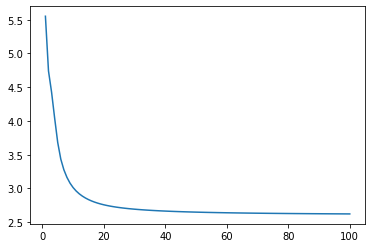

In [109]:
losses=[]
for epoch in range(100):
  batch_losses = 0.0

  for x_batch, y_batch in dataloader:
    y_pred = model(x_batch)
    loss = loss_func(y_pred, y_batch)
    batch_losses+=loss.item()
    
    #Delete previously stored gradients
    optimizer.zero_grad()
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    #Update model's weights based on the gradients calculated during backprop
    optimizer.step()
  losses.append(batch_losses/len(dataloader))
  print(f"Epoch {epoch:3}: Loss = {batch_losses/len(dataloader):.5f}")

plt.plot(list(range(1,101)),losses)

In [110]:
def binary(lis):
  res=[]
  for i in lis:
    if i>=0.5:
      res.append(1)
    elif i<=1:
      res.append(0)
    else:
      print(i)
  return res

F1 Score Train: 0.8272017837235228
F1 Score Validation: 0.8381708968419552
F1 Score Train: 0.8494645405456549
F1 Score Validation: 0.8381708968419552
F1 Score Train: 0.8487015943103147
F1 Score Validation: 0.8381708968419552
F1 Score Train: 0.8458275118930857
F1 Score Validation: 0.8381708968419552
F1 Score Train: 0.8443486408029841
F1 Score Validation: 0.8381708968419552
F1 Score Train: 0.8462865361464917
F1 Score Validation: 0.8381708968419552
F1 Score Train: 0.8432970400608688
F1 Score Validation: 0.8381708968419552
F1 Score Train: 0.8432736632405715
F1 Score Validation: 0.8381708968419552
F1 Score Train: 0.8441093142845644
F1 Score Validation: 0.8381708968419552
F1 Score Train: 0.8451810319931926
F1 Score Validation: 0.8381708968419552


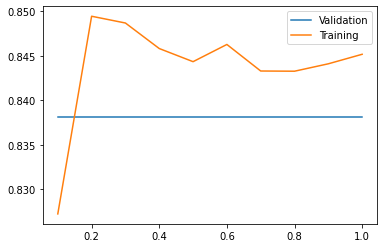

In [111]:
list_f1=[]
list_f1_train=[]
list_sample_size=[]

for times in range(10):
  # training
  #
  X, X_unused, y, y_unused = train_test_split(X_train_tor, Y_train_tor, test_size=1 - (times * 0.1 + 0.001))


  results_train = model(X)

  # validation
  # 
  results = model(X_test_tor)

  # score
  #
  f1_train = f1_score(np.array(y.detach().numpy()), binary(results_train), average='macro')
  print("F1 Score Train: " + str(f1_train))

  f1 = f1_score(Y_test, binary(results), average='macro')
  print("F1 Score Validation: " + str(f1))

  list_f1.append(f1)
  list_f1_train.append(f1_train)
  list_sample_size.append((times * 0.1 + 0.1))

# print(plot_data)
plt.plot(list_sample_size, list_f1)
plt.plot(list_sample_size, list_f1_train)


plt.legend(["Validation", "Training"])

In [112]:
predictions_train = binary(model(X_train_tor))
predictions_val = binary(model(X_test_tor))


# F-Score

f1_train = f1_score(Y_train, predictions_train)
f1_val = f1_score(Y_test, predictions_val)

print("F1 Score (train):", f1_train)
print("F1 Score (validation):", f1_val)

# Recall

r_train = recall_score(Y_train, predictions_train)
r_val = recall_score(Y_test, predictions_val)

print("Recall Score (train):", r_train)
print("Recall Score (validation):", r_val)

# Prediction score

p_train = precision_score(Y_train, predictions_train)
p_val = precision_score(Y_test, predictions_val)

print("Precision Score (train):", p_train)
print("Precision Score (validation):", p_val)


F1 Score (train): 0.8423349699945445
F1 Score (validation): 0.8367087661609746
Recall Score (train): 0.8336403480912151
Recall Score (validation): 0.8274944567627495
Precision Score (train): 0.8512128680762745
Precision Score (validation): 0.846130592503023


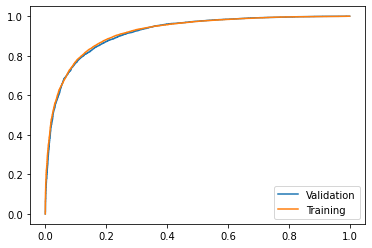

In [113]:
fptr, tptr, thresholdstr=roc_curve(Y_train, model(X_train_tor).detach().numpy())
fpte, tpte, thresholdste=roc_curve(Y_test, model(X_test_tor).detach().numpy())

plt.plot(fpte,tpte)
plt.plot(fptr,tptr)
plt.legend(["Validation", "Training"])